## Importing necessary modules

In [1]:
# gensim modules
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

# numpy
import numpy

# classifier
from sklearn.linear_model import LogisticRegression

# random
import random
from sklearn.pipeline import Pipeline

## Importing dataset

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd

def load_data():

    data_df = pd.read_excel('/content/drive/My Drive/dataset/dataset.xlsx', engine='openpyxl')

    data_df.to_csv('output_reviews_top.csv')

load_data()

In [4]:
top_data_df = pd.read_csv('output_reviews_top.csv')
print("Columns in the original dataset:\n")
print(top_data_df.columns)

Columns in the original dataset:

Index(['Unnamed: 0', 'URL', 'Text', 'Sentiment'], dtype='object')


## Data cleaning and analysing

Number of rows per star rating:
NEG    1000
POS     999
Name: Sentiment, dtype: int64


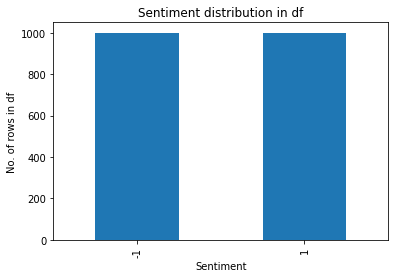

In [5]:
import matplotlib.pyplot as plt 

print("Number of rows per star rating:")
print(top_data_df['Sentiment'].value_counts())

# Function to map stars to sentiment
def map_sentiment(sentiment):
    if sentiment == 'NEG':
        return -1
    else:
        return 1
# Mapping stars to sentiment into three categories
top_data_df['Sentiment_value'] = [map_sentiment(x) for x in top_data_df['Sentiment']]
# Plotting the sentiment distribution
plt.figure()
pd.value_counts(top_data_df['Sentiment_value']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [6]:
# Function to retrieve top few number of each category
def get_top_data(top_n):
    top_data_df_positive = top_data_df[top_data_df['Sentiment_value'] == 1].head(top_n)
    top_data_df_negative = top_data_df[top_data_df['Sentiment_value'] == -1].head(top_n)
    top_data_df_small = pd.concat([top_data_df_positive, top_data_df_negative])
    return top_data_df_small, top_data_df_positive, top_data_df_negative

# Function call to get the top 10000 from each sentiment
top_data_df_small, pos_review, neg_review = get_top_data(999)

# After selecting top few samples of each sentiment
print("After segregating and taking equal number of rows for each sentiment:")
print(top_data_df_small['Sentiment_value'].value_counts())
top_data_df_small.head(10)

After segregating and taking equal number of rows for each sentiment:
 1    999
-1    999
Name: Sentiment_value, dtype: int64


,Unnamed: 0,URL,Text,Sentiment,Sentiment_value
0,0,http://www.imdb.com/title/tt0210075/usercomments,Girlfight follows a project dwelling New York ...,POS,1
1,1,http://www.imdb.com/title/tt0337640/usercomments,Hollywood North is an euphemism from the movie...,POS,1
2,2,http://www.imdb.com/title/tt0303549/usercomments,That '70s Show is definitely the funniest show...,POS,1
3,3,http://www.imdb.com/title/tt0716825/usercomments,"9/10- 30 minutes of pure holiday terror. Okay,...",POS,1
4,4,http://www.imdb.com/title/tt0182225/usercomments,"A series of random, seemingly insignificant th...",POS,1
5,5,http://www.imdb.com/title/tt0347779/usercomments,A very good adaptation of the novel by amrita ...,POS,1
6,6,http://www.imdb.com/title/tt0095655/usercomments,"Ah, Moonwalker, I'm a huge Michael Jackson fan...",POS,1
7,7,http://www.imdb.com/title/tt0298131/usercomments,Although the beginning of the movie in New Yor...,POS,1
8,8,http://www.imdb.com/title/tt0088915/usercomments,"As many reviewers here have noted, the film ve...",POS,1
9,9,http://www.imdb.com/title/tt0828154/usercomments,"Bear in mind, any film (let alone documentary)...",POS,1


## Dataset Splitting

In [7]:
from sklearn.model_selection import train_test_split

X_train_pos, X_test_pos, Y_train_pos, Y_test_pos = train_test_split(pos_review['Text'], 
                                                        pos_review['Sentiment_value'], 
                                                        random_state=15)

In [8]:
from sklearn.model_selection import train_test_split

X_train_neg, X_test_neg, Y_train_neg, Y_test_neg = train_test_split(neg_review['Text'], 
                                                        neg_review['Sentiment_value'], 
                                                        random_state=15)

In [9]:
X_train_pos.shape, X_train_neg.shape

((749,), (749,))

In [10]:
X_test_pos.shape, X_test_neg.shape

((250,), (250,))

In [11]:
X_train_pos.to_csv(r'train-pos.txt', header=None, index=None, sep=' ', mode='a')
X_train_neg.to_csv(r'train-neg.txt', header=None, index=None, sep=' ', mode='a')
X_test_pos.to_csv(r'test-pos.txt', header=None, index=None, sep=' ', mode='a')
X_test_neg.to_csv(r'test-neg.txt', header=None, index=None, sep=' ', mode='a')

In [12]:
class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources
        
        flipped = {}
        
        # make sure that keys are unique
        for key, value in sources.items():
            if value not in flipped:
                flipped[value] = [key]
            else:
                raise Exception('Non-unique prefix encountered')
    
    def __iter__(self):
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    yield LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no])
    
    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no]))
        return self.sentences
    
    def sentences_perm(self):
        shuffled = list(self.sentences)
        random.shuffle(shuffled)
        return shuffled

In [13]:
sources = {'test-neg.txt':'TEST_NEG', 'test-pos.txt':'TEST_POS', 'train-neg.txt':'TRAIN_NEG', 'train-pos.txt':'TRAIN_POS'}

sentences = LabeledLineSentence(sources)

## Doc to vector: 

In [14]:
import gensim
model = gensim.models.Doc2Vec(vector_size=300, window=10, min_count=5, workers=11,alpha=0.025, min_alpha=0.025, epochs=20)
model.build_vocab(sentences.to_array())
model.train(sentences.to_array(), epochs=model.iter, total_examples=model.corpus_count)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  after removing the cwd from sys.path.


In [15]:
model.most_similar('good')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('mediocre', 0.3071358799934387),
 ('nice', 0.2950599193572998),
 ('excellent', 0.26882946491241455),
 ('interesting', 0.2678501009941101),
 ('good.', 0.2642803192138672),
 ('effective.', 0.2637708783149719),
 ('superb', 0.24829038977622986),
 ('solid', 0.2452278733253479),
 ('fine', 0.23733077943325043),
 ('good,', 0.23542582988739014)]

In [16]:
model['TRAIN_NEG_0']

array([ 1.095671  ,  0.00717629,  0.28079307, -0.16983812,  0.2820339 ,
        0.05735643,  0.5925636 ,  0.4694259 ,  0.10915232, -0.4761697 ,
        0.13854563, -0.27969617,  0.6951446 ,  0.9157932 ,  0.35301104,
       -0.4949389 , -0.86905664,  0.48165712,  0.1746926 ,  0.4392855 ,
        0.43516627,  0.47208145, -0.5679434 ,  0.13417351, -0.7287388 ,
        0.84886926, -0.79006207,  0.38959417, -0.82529485,  0.03120219,
       -0.00282664, -0.6090412 , -0.44942608, -0.6743061 , -1.5048629 ,
        0.87639344,  0.31255218,  0.30007532, -0.70307267, -1.3192974 ,
        0.5565921 ,  0.5361204 , -0.9617022 , -0.8928383 ,  0.18892965,
        0.61704874,  0.10736828,  0.9771666 ,  1.3513553 ,  0.56517655,
       -0.7213032 ,  0.32775798, -0.5786961 ,  0.9006983 ,  0.5096848 ,
       -0.5074681 ,  0.01321952, -0.39962286,  0.5078391 ,  0.59525543,
        1.0509002 , -1.4565307 , -1.1114244 ,  1.547754  ,  0.46670696,
        0.7027268 , -0.37143674, -0.1852383 ,  0.69961864,  0.30

## Saving and loading the model:

In [17]:
model.save('./custom_model.d2v')

In [18]:
model = Doc2Vec.load('./custom_model.d2v')

In [19]:
train_arrays = numpy.zeros((1498, 300))
train_labels = numpy.zeros(1498)

for i in range(749):
    prefix_train_pos = 'TRAIN_POS_' + str(i)
    prefix_train_neg = 'TRAIN_NEG_' + str(i)
    train_arrays[i] = model[prefix_train_pos]
    train_arrays[749 + i] = model[prefix_train_neg]
    train_labels[i] = 1
    train_labels[749 + i] = 0

In [20]:
print(train_arrays)

[[ 0.10852978 -0.24347666  0.21917456 ...  0.25693107  0.15984973
   0.18443446]
 [ 0.70967108 -0.31234238  1.42165732 ...  0.69416535  0.19784489
   0.60700399]
 [ 0.50039095  0.14879006  0.37273309 ...  0.0552935  -0.09104238
  -0.03669013]
 ...
 [ 0.85858911  0.25386077  0.51318568 ...  0.08112904  0.06827359
  -0.163085  ]
 [ 0.27882776  0.27370474  0.45493779 ...  0.22501501  0.10853791
  -0.05984343]
 [ 1.35302901  0.16273081  0.44986591 ...  0.63841552  0.51069659
   0.06818765]]


In [21]:
print(train_labels)

[1. 1. 1. ... 0. 0. 0.]


In [22]:
test_arrays = numpy.zeros((500, 300))
test_labels = numpy.zeros(500)

for i in range(250):
    prefix_test_pos = 'TEST_POS_' + str(i)
    prefix_test_neg = 'TEST_NEG_' + str(i)
    test_arrays[i] = model[prefix_test_pos]
    test_arrays[250 + i] = model[prefix_test_neg]
    test_labels[i] = 1
    test_labels[250 + i] = 0

In [23]:
import pickle
from sklearn.metrics import accuracy_score, precision_score 
from sklearn.metrics import recall_score, confusion_matrix, classification_report
def generate_report(pred_list, custom_model, y_test, model_name):
  print(f'Confusion Matrix:\n{confusion_matrix(y_test,pred_list)}')
  print(f'\nClassification Report:\n{classification_report(y_test,pred_list)}')
  acc = accuracy_score(y_test, pred_list) * 100
  print(f'Accuracy: {acc}%')
  prec = precision_score(y_test, pred_list, average='macro') * 100
  print(f'Precision: {prec}%')
  rec = recall_score(y_test, pred_list, average='macro') * 100
  print(f'Recall: {rec}%')
  pickle.dump(custom_model, open(model_name + '.sav', 'wb'))
  print(model_name + ' trained Model Saved')
  return acc, prec, rec

## Logistic Regression:

In [24]:
classifier = LogisticRegression(max_iter=1000)
classifier.fit(train_arrays, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
classifier.score(test_arrays, test_labels)

0.774

In [26]:
LRpred = classifier.predict(test_arrays)

In [27]:
lr_metrics = [None, None, None]
lr_metrics[0], lr_metrics[1], lr_metrics[2] = generate_report(LRpred, classifier, test_labels, 'LinearRegression_model')

Confusion Matrix:
[[189  61]
 [ 52 198]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77       250
         1.0       0.76      0.79      0.78       250

    accuracy                           0.77       500
   macro avg       0.77      0.77      0.77       500
weighted avg       0.77      0.77      0.77       500

Accuracy: 77.4%
Precision: 77.43555648119964%
Recall: 77.4%
LinearRegression_model trained Model Saved


## Bernoulli Naive Bayes:

In [28]:
import pickle
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score

classifier = BernoulliNB()

classifier.fit(train_arrays, train_labels)
BNBpred=classifier.predict(test_arrays)

In [29]:
bnb_metrics = [None, None, None]
bnb_metrics[0], bnb_metrics[1], bnb_metrics[2] = generate_report(BNBpred, classifier, test_labels, 'BernoulliNB_model')

Confusion Matrix:
[[175  75]
 [ 59 191]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.70      0.72       250
         1.0       0.72      0.76      0.74       250

    accuracy                           0.73       500
   macro avg       0.73      0.73      0.73       500
weighted avg       0.73      0.73      0.73       500

Accuracy: 73.2%
Precision: 73.29541803226014%
Recall: 73.2%
BernoulliNB_model trained Model Saved


###Multinomial Naive Bayes(MNB)

In [30]:
from sklearn.naive_bayes import MultinomialNB

In [31]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
train_arrays_norm = min_max_scaler.fit_transform(train_arrays)

In [32]:
classifier = MultinomialNB()
classifier.fit(train_arrays_norm, train_labels)
# MNBmodel.fit(X_train,y_train)
MNBpred=classifier.predict(test_arrays)

In [33]:
mnb_metrics = [None, None, None]
mnb_metrics[0], mnb_metrics[1], mnb_metrics[2] = generate_report(MNBpred, classifier, test_labels, 'MultinomialNB_model')

Confusion Matrix:
[[175  75]
 [ 42 208]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.70      0.75       250
         1.0       0.73      0.83      0.78       250

    accuracy                           0.77       500
   macro avg       0.77      0.77      0.76       500
weighted avg       0.77      0.77      0.76       500

Accuracy: 76.6%
Precision: 77.07169725293514%
Recall: 76.6%
MultinomialNB_model trained Model Saved


## Decision Tree classifier

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [35]:
dt_clf = DecisionTreeClassifier()
# dt_model = Pipeline([("cleaner", predictors()), ('vectorizer', vectorizer), ('classifier', dt_clf)])

# Train the Model
dt_clf.fit(train_arrays, train_labels)   
dt_pred = dt_clf.predict(test_arrays)

In [36]:
dt_metrics = [None, None, None]
dt_metrics[0], dt_metrics[1], dt_metrics[2] = generate_report(dt_pred, dt_clf, test_labels, 'DecisionTree_model')

Confusion Matrix:
[[143 107]
 [106 144]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.57      0.57       250
         1.0       0.57      0.58      0.57       250

    accuracy                           0.57       500
   macro avg       0.57      0.57      0.57       500
weighted avg       0.57      0.57      0.57       500

Accuracy: 57.4%
Precision: 57.40011840189443%
Recall: 57.4%
DecisionTree_model trained Model Saved


In [37]:
train_arrays[:5]

array([[ 0.10852978, -0.24347666,  0.21917456, ...,  0.25693107,
         0.15984973,  0.18443446],
       [ 0.70967108, -0.31234238,  1.42165732, ...,  0.69416535,
         0.19784489,  0.60700399],
       [ 0.50039095,  0.14879006,  0.37273309, ...,  0.0552935 ,
        -0.09104238, -0.03669013],
       [ 0.95182222, -0.26135224,  0.71815544, ...,  1.02142286,
         1.35163629,  0.68188328],
       [ 0.82125646,  0.11760506,  0.22401454, ..., -0.22962822,
         0.01296779,  0.47788537]])

## SVM:

In [38]:
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import classification_report
# pipeline and standard scalar are already imported

In [39]:
%%time
#Train the model
# Perform classification with SVM, kernel=linear
SVMclassifier = svm.SVC(kernel='linear')
# SVMmodel = Pipeline([("cleaner", predictors()), ('vectorizer', vectorizer), ('classifier', SVMclassifier)])
SVMclassifier.fit(train_arrays, train_labels)
SVMpred = SVMclassifier.predict(test_arrays)

CPU times: user 1.87 s, sys: 831 µs, total: 1.87 s
Wall time: 1.88 s


In [40]:
svm_metrics = [None, None, None]
svm_metrics[0], svm_metrics[1], svm_metrics[2] = generate_report(SVMpred, SVMclassifier, test_labels, 'SVM_model')

Confusion Matrix:
[[179  71]
 [ 54 196]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.72      0.74       250
         1.0       0.73      0.78      0.76       250

    accuracy                           0.75       500
   macro avg       0.75      0.75      0.75       500
weighted avg       0.75      0.75      0.75       500

Accuracy: 75.0%
Precision: 75.11613701756924%
Recall: 75.0%
SVM_model trained Model Saved


## Results comparision plots and tables

In [44]:
!pip3 install tabulate
from tabulate import tabulate
table = [['Model Name', 'Accuracy', 'Precision', 'Recall'],
         ['Bernoulli Naïve Bayes', bnb_metrics[0], bnb_metrics[1], bnb_metrics[2]],
         ['Multinomial Naïve Bayes', mnb_metrics[0], mnb_metrics[1], mnb_metrics[2]],
         ['Support Vector Machine', svm_metrics[0], svm_metrics[1], svm_metrics[2]],
         ['Maximum Entropy', lr_metrics[0], lr_metrics[1], lr_metrics[2]],
         ['Decision Tree', dt_metrics[0], dt_metrics[1], dt_metrics[2]]]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════════════════╤════════════╤═════════════╤══════════╕
│ Model Name              │   Accuracy │   Precision │   Recall │
╞═════════════════════════╪════════════╪═════════════╪══════════╡
│ Bernoulli Naïve Bayes   │       73.2 │     73.2954 │     73.2 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ Multinomial Naïve Bayes │       76.6 │     77.0717 │     76.6 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ Support Vector Machine  │       75   │     75.1161 │     75   │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ Maximum Entropy         │       77.4 │     77.4356 │     77.4 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ Decision Tree           │       57.4 │     57.4001 │     57.4 │
╘═════════════════════════╧════════════╧═════════════╧══════════╛


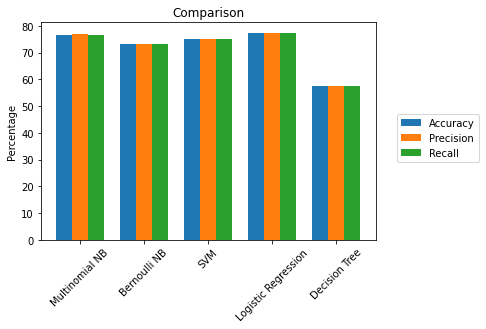

In [45]:
import numpy as np
import matplotlib.pyplot as plt
  
N = 5
ind = np.arange(N) 
width = 0.25
  
acc = [mnb_metrics[0], bnb_metrics[0], svm_metrics[0], lr_metrics[0], dt_metrics[0]]
bar1 = plt.bar(ind, acc, width)
  
prec = [mnb_metrics[1], bnb_metrics[1], svm_metrics[1], lr_metrics[1], dt_metrics[1]]
bar2 = plt.bar(ind+width, prec, width)
  
recall = [mnb_metrics[2], bnb_metrics[2], svm_metrics[2], lr_metrics[2], dt_metrics[2]]
bar3 = plt.bar(ind+width*2, recall, width)
  
# plt.xlabel("Dates")
plt.ylabel("Percentage")
plt.title("Comparison")
  
plt.xticks(ind+width,['Multinomial NB','Bernoulli NB','SVM','Logistic Regression', 'Decision Tree'])
plt.xticks(rotation = 45)
plt.legend( (bar1, bar2, bar3), ('Accuracy', 'Precision', 'Recall'), bbox_to_anchor = (1.05, 0.6))
plt.show()

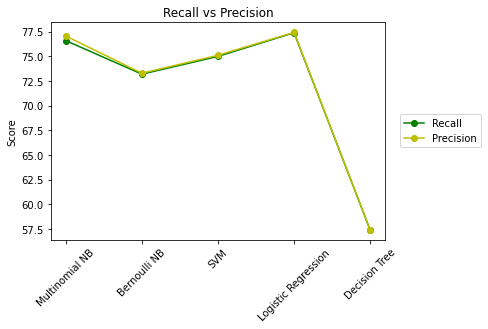

In [46]:
import matplotlib.pyplot as plt
models = ['Multinomial NB','Bernoulli NB','SVM','Logistic Regression', 'Decision Tree']
recall = [mnb_metrics[2], bnb_metrics[2], svm_metrics[2], lr_metrics[2], dt_metrics[2]]
precision = [mnb_metrics[1], bnb_metrics[1], svm_metrics[1], lr_metrics[1], dt_metrics[1]]
line_chart1 = plt.plot(models, recall, 'o-g')
line_chart2 = plt.plot(models, precision, 'o-y')
plt.title('Recall vs Precision')
plt.ylabel('Score')
plt.xticks(rotation = 45)
plt.legend(['Recall', 'Precision'], bbox_to_anchor = (1.3, 0.6))
plt.show()